In [1]:
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt
from rasterio.plot import show
import pandas as pd
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
import matplotlib.colors as mplc
from matplotlib import cm
import matplotlib.patches as mpatches
import json 
import pickle

from utils import legends 

In [2]:
region_name = "Aceh"

resampled = '_resampled'
 
landcover_source = 'copernicus_global_coll3' #copernicus_global_coll3  Corine_Europe_2012

colors_dict = getattr(legends, 'colors_dict_' + landcover_source)
legend_dict = getattr(legends, 'legend_dict_' + landcover_source)

# Get path to this file and then also path to data
dirname = os.getcwd()
data_path = os.path.join(dirname, 'data', region_name)
with open(os.path.join(data_path, region_name+'_EPSG.pkl'), 'rb') as file:
        EPSG = pickle.load(file)

####
#EPSG=3035
####

print(f'EPSG {EPSG}')

landcoverRasterPath = os.path.join(data_path, f'landcover_{region_name}_EPSG{EPSG}.tif')
demRasterPath = os.path.join(data_path, f'DEM_{region_name}_EPSG{EPSG}{resampled}.tif')
slopeRasterPath = os.path.join(data_path, f'slope_{region_name}_EPSG{EPSG}{resampled}.tif')
aspectRasterPath = os.path.join(data_path, f'aspect_{region_name}_EPSG{EPSG}{resampled}.tif')
regionPath = os.path.join(data_path, f'{region_name}_{EPSG}.geojson')
region_boundary = gpd.read_file(regionPath)

EPSG 32647


# Roads, Railways, Airports & Transmission lines
This is still work in progress (airports are polygons, the rest are lines which makes problems with the legend)

region geojson loaded EPSG: EPSG:32647


C:\Users\b396636\AppData\Local\Temp\ipykernel_21524\1687357907.py:22: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


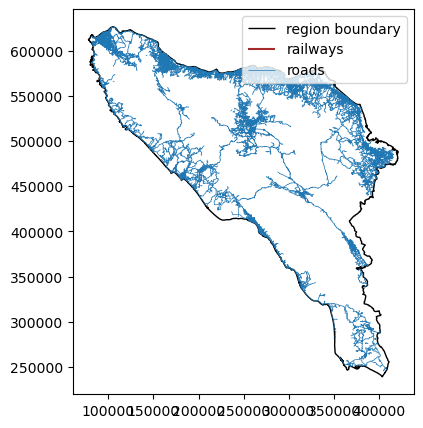

In [3]:
region_boundary = gpd.read_file(regionPath)
print(f'region geojson loaded EPSG: {region_boundary.crs}')

fig, ax = plt.subplots(figsize=(5, 5))
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1, label='region boundary')

try:
    OSM_railways = gpd.read_file(os.path.join(data_path, f'OSM_railways_{region_name}_{EPSG}.geojson'))
    OSM_railways.plot(ax=ax, label='railways', color = 'brown')
except:
    pass
try:
    OSM_airpots = gpd.read_file(os.path.join(data_path, f'OSM_airports_{region_name}_{EPSG}.geojson'))
    OSM_airpots.plot(ax=ax, label='airport', color = 'red')
except:
    pass
try:
    OSM_roads = gpd.read_file(os.path.join(data_path, f'OSM_roads_{region_name}_{EPSG}.geojson'))
    OSM_roads.plot(ax=ax, label='roads', linewidth=0.5)
except:
    pass
ax.legend()

# Landcover Analysis

In [4]:
#inspect land cover data
landcover = rasterio.open(landcoverRasterPath) 

band = landcover.read(1, masked=True) #masked=True is masking no data values
print(f'landcover EPSG: {landcover.crs}')
print(f'bands (number of layers): {landcover.count}')

print(f'band shape: {band.shape}')
print(f'number of cells: {band.shape[0]*band.shape[1]}')
res = landcover.transform[0] #pixel size
#save pixel size
with open(os.path.join(data_path, f'pixel_size_{region_name}_{EPSG}.json'), 'w') as fp:
    json.dump(res, fp)

print(f'pixel size: {res}')

print(landcover.tags(1))

band

landcover EPSG: EPSG:32647
bands (number of layers): 1
band shape: (3525, 3134)
number of cells: 11047350
pixel size: 109.95977722729245
{}


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=255,
  dtype=uint8)

In [5]:
#Available land cover codes
landuses = np.unique(band.data).tolist()

print("the minimum raster value is: ", band.min())
print("the maximum raster value is: ", band.max())
print('nodata value: ', landcover.meta['nodata'])

#save landuses as json file
with open(os.path.join(data_path, f'landuses_{region_name}.json'), 'w') as fp:
    json.dump(landuses, fp)

landuses

the minimum raster value is:  0
the maximum raster value is:  200
nodata value:  255.0


[0, 20, 30, 40, 50, 60, 80, 90, 112, 116, 122, 126, 200, 255]

In [6]:
# Create a DataFrame
df = pd.DataFrame({
    'code': landuses,
    'value': [legend_dict.get(code, 'Not Found') for code in landuses],
    'area (sq km)': ''
})

#add area for each landuse
for index in range(len(df)):
    value = df.at[index,'code']
    #count pixels
    number_pixels = np.count_nonzero(band == value)
    #calculate area
    area = number_pixels * res*res / 1e6
    #save in df
    df.at[index, 'area (sq km)'] = area

no_data_area = df.loc[df['code'] == landcover.meta['nodata'], 'area (sq km)'].iloc[0]
print('total area (sqkm): ' + str(df['area (sq km)'].sum() - no_data_area))
df

total area (sqkm): 54497.12212269165


,code,value,area (sq km)
0,0,Not Found,0.084638
1,20,Shrubs,10.80949
2,30,Herbaceous vegetation,196.59005
3,40,Cultivated and managed vegetation/agriculture ...,2449.425695
4,50,Urban / built up,766.397708
5,60,Bare / sparse vegetation,12.06697
6,80,Permanent water bodies,248.61828
7,90,Herbaceous wetland,611.655137
8,112,"Closed forest, evergreen, broad leaf",42492.034339
9,116,"Closed forest, unknown",3131.366702


{20: 'Shrubs', 30: 'Herbaceous vegetation', 40: 'Cultivated and managed vegetation/agriculture (cropland)', 50: 'Urban / built up', 60: 'Bare / sparse vegetation', 70: 'Snow and Ice', 80: 'Permanent water bodies', 90: 'Herbaceous wetland', 100: 'Moss and lichen', 111: 'Closed forest, evergreen needle leaf', 112: 'Closed forest, evergreen, broad leaf', 113: 'Closed forest, deciduous needle leaf', 114: 'Closed forest, deciduous broad leaf', 115: 'Closed forest, mixed', 116: 'Closed forest, unknown', 121: 'Open forest, evergreen needle leaf', 122: 'Open forest, evergreen broad leaf', 123: 'Open forest, deciduous needle leaf', 124: 'Open forest, deciduous broad leaf', 125: 'Open forest, mixed', 126: 'Open forest, unknown', 200: 'Open sea', 255: 'No input data available'}


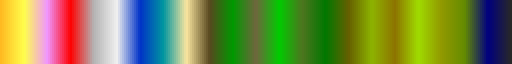

In [7]:
# sort dict and Define your unevenly spaced numbers and corresponding colors
colors_dict = dict(sorted(colors_dict.items()))
landcovercodes = list(colors_dict.keys())
colors = list(colors_dict.values())

# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom", list(zip(np.linspace(0, 1, len(colors)), colors)))

# Create the norm to map your numbers to colors
norm = BoundaryNorm(landcovercodes, cmap.N)

legend_dict = dict(sorted(legend_dict.items()))
print(legend_dict)
cmap

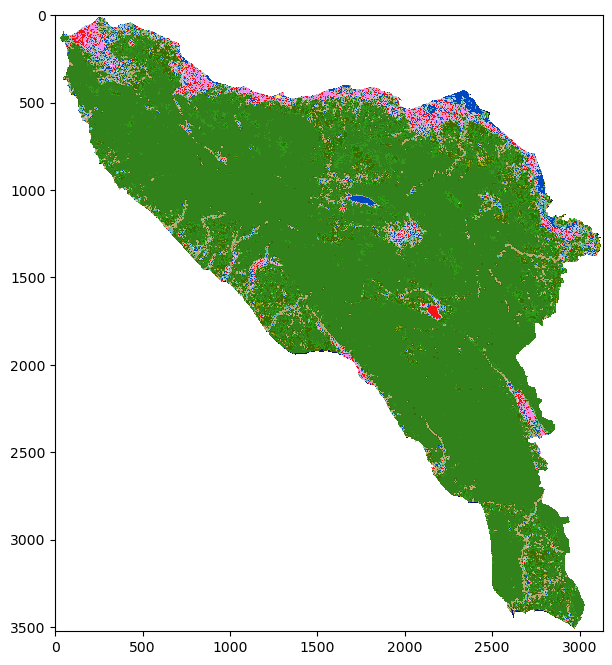

<Axes: >

In [8]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))
show(band, cmap=cmap, norm=norm) #, cmap=landcover_cmap, vmin=20, vmax=len(colors))

#be careful with the coloring, it is not necessarily correct

In [9]:
def plot_single_landuse(land_use_code, band, ax):
    # Create the mask where values not equal to land use code are masked (i.e., set to True)
    mask = (band != land_use_code)
    # Create the masked array
    masked_band = np.ma.masked_array(band, mask=mask)

    # Create a colormap with only one color
    color=colors_dict[land_use_code]
    cmap = LinearSegmentedColormap.from_list('custom_colormap', [color, color])

    show(masked_band, ax=ax, cmap=cmap, norm=norm, transform = landcover.transform)
    ax.set_title(f'land use: {land_use_code} - ' + legend_dict[land_use_code])

    ax.ticklabel_format(axis='both', style='scientific', scilimits=(1,3))

    # Count the number of pixels with the specific value
    num_pixels = np.count_nonzero(masked_band == land_use_code)
    #print(f'eligbible cells: {num_pixels}')
    print(f'area: {round((num_pixels*res*res)/1e6,2)} km²')
    #print(masked_band.sum())




def plot_multiple_landuses(land_use_codes, band, ax, legend=False):
    # Create the mask where values not in land use codes are masked
    mask = ~np.isin(band, land_use_codes)
    
    # Create the masked array
    masked_band = np.ma.masked_array(band, mask=mask)

    # Plot the masked band
    show(masked_band, ax=ax, cmap=cmap, norm=norm, transform=landcover.transform)
    ax.set_title(f'Land uses: {", ".join(map(str, land_use_codes))}')

    ax.ticklabel_format(axis='both', style='scientific', scilimits=(1,3))

    if legend==True:
        # Create legend
        legend_patches = []
        for code in land_use_codes:
            color = cmap(norm(code))
            name =  legend_dict[code]  # Use dict name or fallback
            patch = mpatches.Patch(color=color, label=f'{code}: {name}')
            legend_patches.append(patch)

        fig.legend(handles=legend_patches, loc='center', bbox_to_anchor=(0.5, 0))


area: 766.4 km²


<Axes: title={'center': 'land use: 50 - Urban / built up'}>

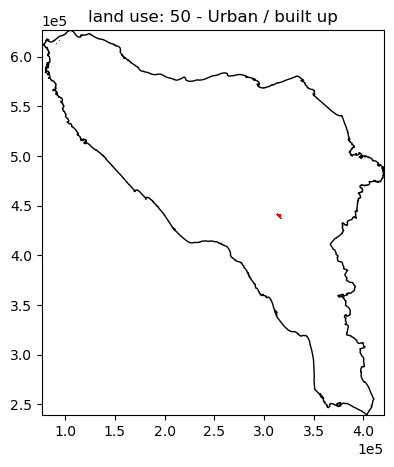

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_single_landuse(50,band,ax)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

<Axes: title={'center': 'Land uses: 50, 80, 111'}>

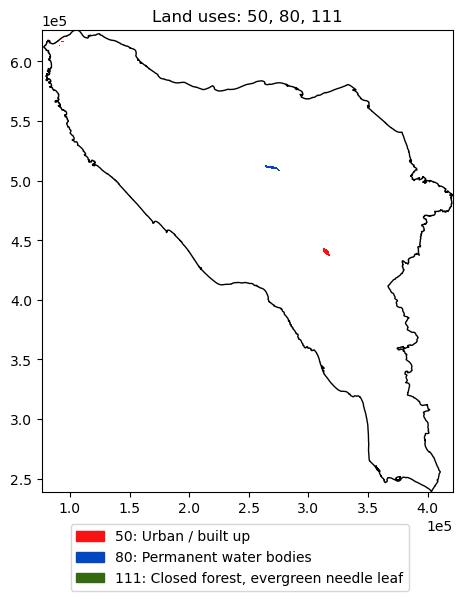

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_multiple_landuses([50,80,111],band,ax, legend=True)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)


In [12]:
landcover.close()

# DEM

In [13]:
#inspect DEM data
dem = rasterio.open(demRasterPath)#, masked=True, nodata=-32767.0) #masked=True is masking no data values --> does not work

band = dem.read(1, masked=True)
print(f'raster EPSG: {dem.crs}')
print(f'bands (number of layers): {dem.count}')

print(f'band shape: {band.shape}')
print(f'number of cells: {band.shape[0]*band.shape[1]}')
res = dem.transform[0] #pixel size
print(f'pixel size: {res}')

print(dem.tags(1))

band 

landcover EPSG: EPSG:32647
bands (number of layers): 1
band shape: (3525, 3134)
number of cells: 11047350
pixel size: 109.95977722729245
{}


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=int16)

In [14]:
print("the minimum raster value is: ", band.min())
print("the maximum raster value is: ", band.max())
print('nodata value: ', dem.meta['nodata'])

the minimum raster value is:  -13
the maximum raster value is:  3375
nodata value:  0.0


<Axes: >

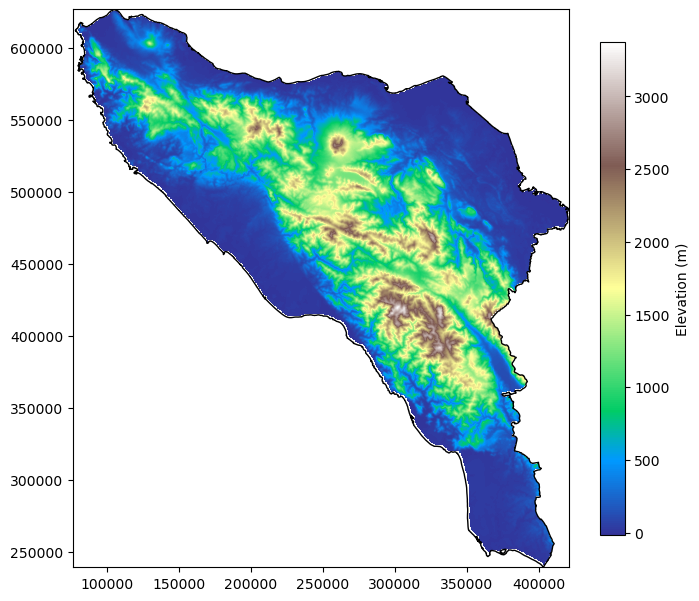

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))

cmap = 'terrain'
norm = mplc.Normalize(vmin=np.nanmin(band), vmax=np.nanmax(band))
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Elevation (m)',shrink=0.8)

show(band, ax=ax, transform = dem.transform, cmap=cmap, norm=norm)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

In [16]:
def plot_elevations(above_below, height, band, ax):
    if above_below == 'below':   
        # Create the mask where values higher than height are masked (i.e., set to True)
        mask = (band > height) #| (band == dem.meta['nodata'])
    if above_below == 'above':   
        # Create the mask where values lower than height are masked (i.e., set to True)
        mask = (band < height) #| (band == dem.meta['nodata'])
    # Create the masked array
    masked_band = np.ma.masked_array(band, mask=mask)

    norm = mplc.Normalize(vmin=np.nanmin(band), vmax=np.nanmax(band))

    cmap = 'terrain'
    show(masked_band, ax=ax, transform = dem.transform, cmap=cmap, norm=norm)
    ax.set_title(f'only heights {above_below}: {height}')

    # Add colorbar
    #fig.colorbar(im, ax=ax, orientation='vertical', label='Elevation (m)')
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Elevation (m)',shrink=0.8)




<Axes: title={'center': 'only heights above: 1200'}>

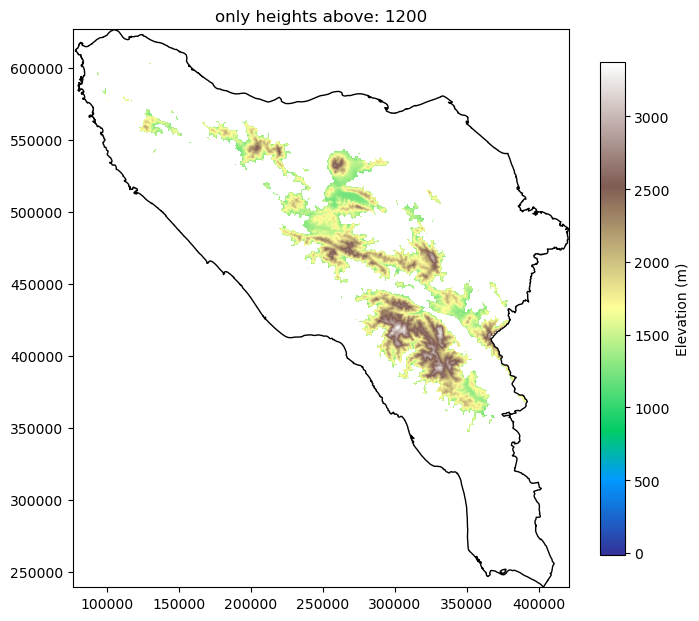

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_elevations('above', 1200, band, ax)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

In [18]:
dem.close()

# Slope

In [19]:
#inspect slope data
slope = rasterio.open(slopeRasterPath)#, masked=True, nodata=-32767.0) #masked=True is masking no data values --> does not work

band = slope.read(1, masked=True)
print(f'raster EPSG: {slope.crs}')
print(f'bands (number of layers): {slope.count}')

print(f'band shape: {band.shape}')
print(f'number of cells: {band.shape[0]*band.shape[1]}')
res = slope.transform[0] #pixel size
print(f'pixel size: {res}')

print(slope.tags(1))

band 

landcover EPSG: EPSG:32647
bands (number of layers): 1
band shape: (3525, 3134)
number of cells: 11047350
pixel size: 109.95977722729245
{}


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-9999.0,
  dtype=float32)

In [20]:
print("the minimum raster value is: ", band.min())
print("the maximum raster value is: ", band.max())
print('nodata value: ', slope.meta['nodata'])

the minimum raster value is:  0.0
the maximum raster value is:  45.180595
nodata value:  -9999.0


<Axes: >

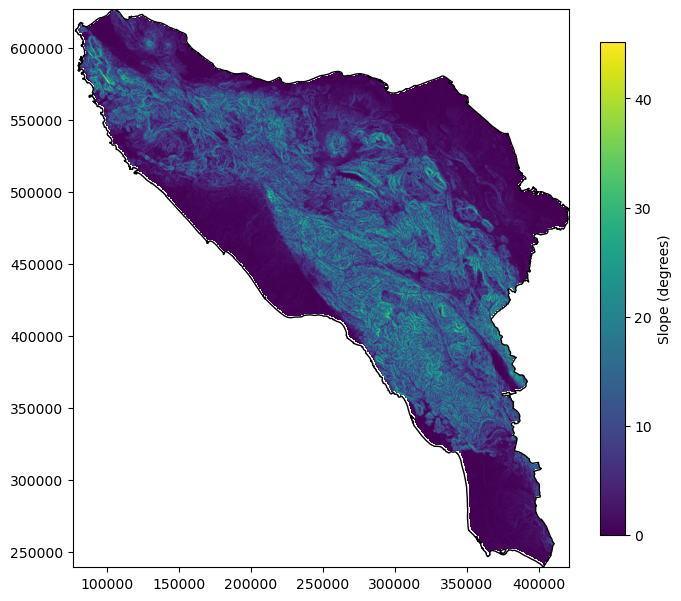

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))

cmap = 'viridis'
norm = mplc.Normalize(vmin=np.nanmin(band), vmax=np.nanmax(band))
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Slope (degrees)',shrink=0.8)

show(band, ax=ax, transform = slope.transform, cmap=cmap, norm=norm)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

In [22]:
slope.close()

# Aspect

In [23]:
#inspect slope data
aspect = rasterio.open(aspectRasterPath)#, masked=True, nodata=-32767.0) #masked=True is masking no data values --> does not work

band = aspect.read(1, masked=True)
print(f'raster EPSG: {aspect.crs}')
print(f'bands (number of layers): {aspect.count}')

print(f'band shape: {band.shape}')
print(f'number of cells: {band.shape[0]*band.shape[1]}')
res = aspect.transform[0] #pixel size
print(f'pixel size: {res}')

print(aspect.tags(1))

landcover EPSG: EPSG:32647
bands (number of layers): 1
band shape: (3525, 3134)
number of cells: 11047350
pixel size: 109.95977722729245
{}


In [24]:
print("the minimum raster value is: ", band.min())
print("the maximum raster value is: ", band.max())
print('nodata value: ', aspect.meta['nodata'])

the minimum raster value is:  0.0
the maximum raster value is:  359.89526
nodata value:  -9999.0


<Axes: >

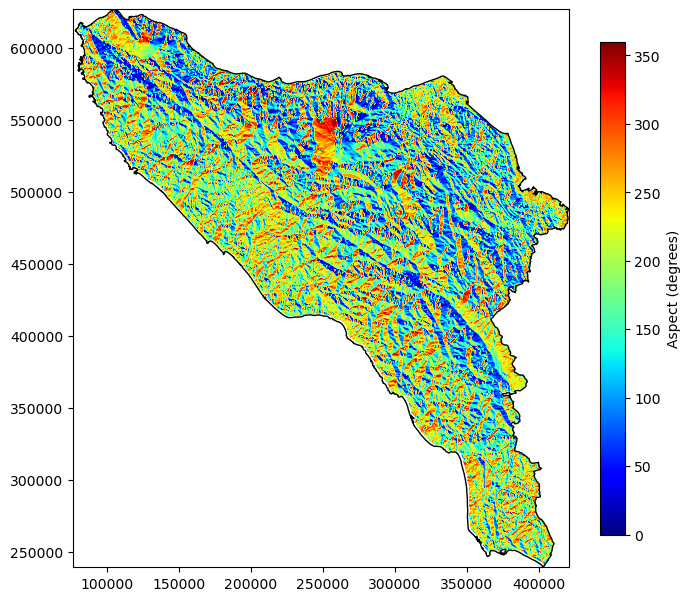

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))

cmap = 'jet'
norm = mplc.Normalize(vmin=np.nanmin(band), vmax=np.nanmax(band))
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Aspect (degrees)',shrink=0.8)

show(band, ax=ax, transform = aspect.transform, cmap=cmap, norm=norm)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

#0° represents North, 90° represents East, 180° represents South, 270° represents West

In [ ]:
aspect.close()